In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import pandas as pd 
import numpy as np 
import mne
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import * 

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

import keras
from keras import regularizers
from keras.models import Model, load_model, Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.constraints import max_norm
from keras.preprocessing import sequence
from keras.utils import to_categorical

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [3]:
#load dataset from ramdisk and get labels
with open("G:\IN.txt", 'r') as temp_f:
    # get No of columns in each line
    col_count = [ len(l.split(",")) for l in temp_f.readlines() ]

### Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1)
column_names = [i for i in range(0, max(col_count))]

In [4]:
#clean up namespace
del temp_f
del col_count

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [5]:
#load dataset from ramdisk and get labels
url = 'G:\IN.txt'
raw = pd.read_csv(url,low_memory=False,header= None,delimiter=",", names=column_names)

In [6]:
tmp = raw[0].str.split('\t').tolist()[:] # [:-1] means exclude last


In [7]:
#Y labels
labels = []

num_trials = int(len(tmp)/5)

for deek in range(num_trials):
    val = 5 * (deek)
    labels.append(tmp[val][4])

In [8]:
raw = raw.fillna(axis=0, method='backfill')
raw = raw.fillna(axis=0, method='ffill')
raw = raw.iloc[: , 1:]
raw.head(15)

,1,2,3,4,5,6,7,8,9,10,...,262,263,264,265,266,267,268,269,270,271
0,4237.948717,4247.179487,4242.051282,4233.333333,4251.282051,4232.820512,4234.358974,4224.615384,4219.487179,4249.743589,...,4302.051282,4300.0,4347.179487,4345.641025,4358.461538,4348.205128,4308.205128,4305.128205,4297.948717,4299.487179
1,4100.512820,4102.564102,4087.692307,4074.358974,4095.897435,4093.846153,4120.000000,4123.589743,4107.179487,4118.974358,...,4302.051282,4300.0,4347.179487,4345.641025,4358.461538,4348.205128,4308.205128,4305.128205,4297.948717,4299.487179
2,4218.461538,4242.051282,4245.128205,4233.333333,4257.435897,4241.025641,4241.538461,4231.282051,4230.256410,4261.538461,...,4302.051282,4300.0,4347.179487,4345.641025,4358.461538,4348.205128,4308.205128,4305.128205,4297.948717,4299.487179
3,4188.717948,4204.102564,4198.461538,4179.487179,4203.589743,4194.871794,4185.128205,4174.358974,4183.589743,4208.717948,...,4302.051282,4300.0,4347.179487,4345.641025,4358.461538,4348.205128,4308.205128,4305.128205,4297.948717,4299.487179
4,4203.589743,4188.717948,4186.666666,4198.461538,4177.435897,4192.820512,4174.871794,4176.410256,4205.641025,4174.358974,...,4302.051282,4300.0,4347.179487,4345.641025,4358.461538,4348.205128,4308.205128,4305.128205,4297.948717,4299.487179
5,4265.641025,4270.256410,4284.615384,4265.128205,4279.487179,4268.717948,4270.256410,4288.717948,4266.666666,4274.358974,...,4302.051282,4300.0,4347.179487,4345.641025,4358.461538,4348.205128,4308.205128,4305.128205,4297.948717,4299.487179
6,4252.307692,4262.564102,4244.102564,4217.435897,4262.564102,4239.487179,4211.282051,4252.820512,4247.179487,4234.358974,...,4302.051282,4300.0,4347.179487,4345.641025,4358.461538,4348.205128,4308.205128,4305.128205,4297.948717,4299.487179
7,4301.025641,4293.333333,4289.230769,4285.128205,4320.000000,4302.051282,4298.461538,4312.307692,4270.256410,4290.256410,...,4302.051282,4300.0,4347.179487,4345.641025,4358.461538,4348.205128,4308.205128,4305.128205,4297.948717,4299.487179
8,4210.769230,4198.974358,4215.897435,4218.974358,4238.461538,4218.974358,4196.923076,4202.051282,4205.641025,4246.666666,...,4302.051282,4300.0,4347.179487,4345.641025,4358.461538,4348.205128,4308.205128,4305.128205,4297.948717,4299.487179
9,4216.410256,4233.846153,4215.384615,4238.461538,4235.897435,4236.410256,4228.717948,4207.692307,4234.358974,4209.743589,...,4302.051282,4300.0,4347.179487,4345.641025,4358.461538,4348.205128,4308.205128,4305.128205,4297.948717,4299.487179


In [9]:
n_channels = 5
sampling_freq = 128  # in Hertz
info = mne.create_info(n_channels, sfreq=sampling_freq)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: 0, 1, 2, 3, 4
 chs: 5 misc
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 5
 projs: []
 sfreq: 128.0 Hz
>


In [10]:
ch_names = ['AF3','AF4','T7','T8','Pz']
ch_types = ['eeg'] * 5
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
info.set_montage('standard_1020')
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: AF3, AF4, T7, T8, Pz
 chs: 5 EEG
 custom_ref_applied: False
 dig: 8 items (3 Cardinal, 5 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 5
 projs: []
 sfreq: 128.0 Hz
>

<Info | 8 non-empty values
 bads: []
 ch_names: AF3, AF4, T7, T8, Pz
 chs: 5 EEG
 custom_ref_applied: False
 dig: 8 items (3 Cardinal, 5 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 5
 projs: []
 sfreq: 128.0 Hz
>


In [11]:
info['description'] = 'MNIST visualization dataset http://mindbigdata.com/opendb/index.html'
print(info)

<Info | 9 non-empty values
 bads: []
 ch_names: AF3, AF4, T7, T8, Pz
 chs: 5 EEG
 custom_ref_applied: False
 description: MNIST visualization dataset http://mindbigdata.com/opendb/index.html
 dig: 8 items (3 Cardinal, 5 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 5
 projs: []
 sfreq: 128.0 Hz
>


In [12]:
epochsOfMagic = []
lengthMagic = int(raw.shape[0]/5)
for zx in range(lengthMagic):
    val_beg = 5 * (zx)
    val_end = 5 * (zx+1)
    epochsOfMagic.append(raw.iloc[val_beg:val_end].to_numpy())
del pd
del raw

In [13]:
raw = mne.EpochsArray(epochsOfMagic, info)

Not setting metadata
13050 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


In [14]:
del epochsOfMagic

    Using multitaper spectrum estimation with 7 DPSS windows


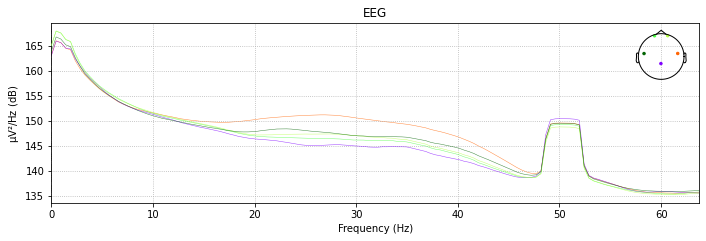

IndexError: index 10 is out of bounds for axis 0 with size 10

In [15]:
#fmax = 70 :AC
fig = raw.plot_psd(tmax=np.inf, fmax=64, average=False)
for ax in fig.axes[1:]:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    for freq in (60, 120, 180):
        idx = np.searchsorted(freqs, freq)
        ax.arrow(x=freqs[idx], y=psds[idx] + 18, dx=0, dy=-12, color='red',
                 width=0.1, head_width=3, length_includes_head=True)
#no arrows means it is clean data with no powerline artifacts.

In [18]:
teste = raw.to_data_frame(scalings=dict(eeg=1, mag=1, grad=1), index='epoch').drop(['condition','time'],axis=1)

In [19]:
teste.head(271)

,AF3,AF4,T7,T8,Pz
epoch,,,,,
0,4237.948717,4100.512820,4218.461538,4188.717948,4203.589743
0,4247.179487,4102.564102,4242.051282,4204.102564,4188.717948
0,4242.051282,4087.692307,4245.128205,4198.461538,4186.666666
0,4233.333333,4074.358974,4233.333333,4179.487179,4198.461538
0,4251.282051,4095.897435,4257.435897,4203.589743,4177.435897
...,...,...,...,...,...
0,4348.205128,4348.205128,4348.205128,4348.205128,4348.205128
0,4308.205128,4308.205128,4308.205128,4308.205128,4308.205128
0,4305.128205,4305.128205,4305.128205,4305.128205,4305.128205


In [20]:
import numpy
import pywt
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
del raw

In [21]:
teste = numpy.transpose(teste.to_numpy())

In [22]:
dataOut=[]
lengthData = int(teste.shape[1]/271)
for z in range(lengthData):
    val_beg = 271 * (z)
    val_end = 271 * (z+1)
    coef, freqs = pywt.cwt(teste[:,val_beg:val_end],271,'morl',method='fft')
    dataOut.append(np.array(min_max_scaler.fit_transform(coef[0])))
    print(str(z/lengthData*100),end='\r')

In [ ]:
del teste

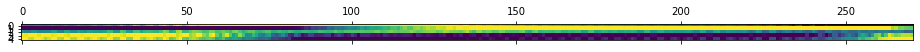

(5, 271)

In [24]:
import matplotlib.pyplot as plt
plt.matshow(dataOut[1]) # doctest: +SKIP
plt.show() # doctest: +SKIP
dataOut[3].shape

In [25]:
## from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataOut,
                                                   labels,
                                                   test_size=0.20,
                                                   random_state=42)

y_train_cat, y_test_cat = to_categorical(y_train), to_categorical(y_test)

In [26]:
#### input_shape = (numpy array from raw)
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

model = models.Sequential()

batches = 14
#model.add(layers.Conv2D(filters = 2,  kernel_size = (1,2), strides= (1,1), activation = 'relu', dilation_rate = 2, input_shape = [135, 14 , 1]))
#model.add(layers.Conv2D(filters = 2, kernel_size = (1,2), strides = (1,1), activation = 'relu', dilation_rate = 2))

model.add(layers.DepthwiseConv2D(kernel_size = (1,2), strides= 2, activation = 'relu', padding = 'same', depth_multiplier = 8, input_shape = [5,271,1]))
model.add(layers.DepthwiseConv2D(kernel_size = (1,2), strides = 2, activation = 'relu', padding = 'same', depth_multiplier = 16))
model.add(layers.MaxPooling2D(pool_size = (1,2), padding = 'same')) #play around with pool_size 
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu')) #128
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))
patience=2
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = ['val_loss']
accuracy = tf.keras.metrics.CategoricalAccuracy()
model.compile(loss = loss, optimizer = optimizer,
    metrics=[
        tf.keras.metrics.MeanSquaredError(), 'accuracy'],)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 depthwise_conv2d_2 (Depthwi  (None, 3, 136, 8)        24        
 seConv2D)                                                       
                                                                 
 depthwise_conv2d_3 (Depthwi  (None, 2, 68, 128)       384       
 seConv2D)                                                       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 34, 128)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 8704)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               1114240   
                                                      

In [30]:
model.fit(numpy.array(X_train), y_train_cat, epochs=1)


327/327 [==============================] - 2s 6ms/step - loss: 0.1555 - mean_squared_error: 0.0059 - accuracy: 0.9623


In [28]:
model.save_weights('model')